## Численные методы. Задание 3.2
#### Козловский А.А., гр. 2253
#### Вариант 5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import display, Markdown

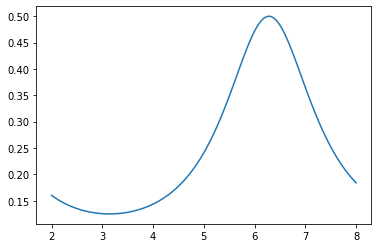

In [2]:
f = lambda x: 1 / (5 - 3 * np.cos(x))
a, b = 2, 8
x = np.linspace(a, b, 100)

plt.plot(x, f(x))
plt.show()

In [3]:
def make_value_table(start, end, count, f):
    """Функция для построения таблицы узлов
    start: левая граница интервала
    end: правая граница интервала
    count: количество узлов
    f: функция
    returns: таблицу узлов"""
    x_table = np.linspace(start, end, count)
    y_table = np.array([f(x) for x in x_table])
    
    result = np.concatenate(([x_table], [y_table]))
    return result

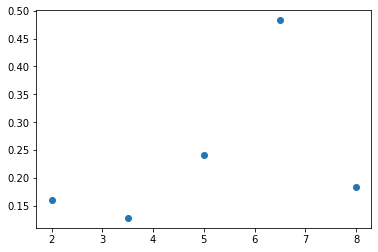

In [4]:
table_count = 5
# x_table = np.linspace(a, b, table_count)
# y_table = np.array([f(x) for x in x_table])

# value_table = np.concatenate(([x_table], [y_table]))
value_table = make_value_table(a, b, table_count, f)
plt.scatter(value_table[0], value_table[1])
plt.show()

In [5]:
df_table = pd.DataFrame(columns=[f'x{i}' 
                                 for i, _ in enumerate(value_table.T)],
                        index=['x', 'f(x)'], data=value_table)
display(df_table)

,x0,x1,x2,x3,x4
x,2.00000,3.500000,5.000000,6.500000,8.000000
f(x),0.16004,0.128051,0.241021,0.483036,0.183942


#### Интерполяция многочленом Лагранжа
Так кусочно-линейная и кусочно-квадратичная интерполяции - частные случаи интерполяции многочленом Лагранжа, то будем реализовывать функцию позволяющую производить интерполяцию многочленом Лагранжа n-ой степени вокруг указанной точки.

Многочлен Лагранжа n-ой степени имеет вид:
$$P_{n}(x) = \sum_{i=1}^{n} y_{i} \prod_{j=0, j \neq i}^{n} \frac{x - x_{j}}{x_{i} - x_{j}} $$

В нашей функции, на вход которой будет поступать координата точки по оси Ox и таблица узлов, будем находить n ближайших по оси Ox узлов и производить интерполяцию по ним.

In [6]:
def lagrange(point, table, n):
    """Функция для проведение интерполяции
    многочленом Лагранжа
    point: координата точки
    tabel: таблица узлов интерполяции
    n: степень многочлена Лагранжа
    returns: лямбда функция полученная в ходе интерполяции,
    значение в точке point полученной функции"""
    def mult(array, without=None):
        """Функция для рассчета произведения ряда
        array: ряд
        without: элемент, который не включается в произведение
        returns: результат произведения"""
        result = 1
        for i, value in enumerate(array):
            if i != without:
                result *= value
        return result
    
    
    x_, y_ = table[0], table[1]
    x_inter = np.argsort(np.abs(point - x_))[:n+1]
    x_ = np.array([x_[i] for i in x_inter])
    y_ = np.array([y_[i] for i in x_inter])
    polynom = np.zeros(n+1)
    
    f = lambda x: np.sum([y_[i] * mult([x - vx for vx in x_], i) / 
                          mult([x_[i] - vx for vx in x_], i)
                          for i, v in enumerate(x_)])
    
    return f, f(point)

Определим функции для более удобного проведения интерполяций и анализа

In [7]:
def estimate(point_x, value_table, n, f, x):
    """Функция для оценки точности приближения
    многочленом Лагранжа и визуализации результатов
    point_x: точка, около которой идет интреполяция
    value_table: таблица с узлами исходной функции
    n: степень многочлена Лагранжа
    f: исходная функция (лямбда функция)
    x: массив значений x"""
    res = lagrange(point_x, value_table, n)
    error = np.abs(res[1] - f(point_x))
    display(Markdown(rf"""<b>Оценка приближения многочленом лагранжа {n}-ой степени</b> <p>
    Отклонение найденной точки от действительной по оси Oy
    составило {error:.5f}"""))

    fig, ax = plt.subplots()

    ax.plot(x, f(x), label='Исходная функция')
    line, = ax.plot(x, [res[0](x_) for x_ in x], label=f'Лагранж n={n}')
    ax.scatter(value_table[0], value_table[1], label='Узлы')
    ax.scatter(point_x, res[1], marker='X', color='orange',
                s=150, linewidths=2, edgecolors='black',
                label='Наша точка')
    ax.legend()
    plt.show()
    
    return line

In [8]:
def estimate_several(point_x, value_table, degrees, colors, f, x):
    """Функция для оценки точности приближения
    многочленами Лагранжа и визуализация результатов
    point_x: точка, около которой идет интреполяция
    value_table: таблица с узлами исходной функции
    degrees: массив степеней многочленов Лагранжа
    colors: массив цветов для отрисовки графиков 
    многочленов Лагранжа
    f: исходная функция (лямбда функция)
    x: массив значений x
    returns: датафрейм с данным по точкам, полученным в результате
    интерполяций"""
    errors = np.zeros((len(degrees)))
    data, columns = [], ['x', 'y', 'error', 'degree']

    fig, ax = plt.subplots()
    ax.plot(x, f(x), label='Исходная функция')
    ax.scatter(value_table[0], value_table[1], label='Узлы')
    
    for i, degree in enumerate(degrees):
        res = lagrange(point_x, value_table, degree)
        errors[i] = np.abs(res[1] - f(point_x))
        data.append([point_x, res[0](point_x), errors[i], degree])
        
        ax.plot(x, [res[0](x_) for x_ in x], label=f'Лагранж n={degree}',
                color=colors[i])
        ax.scatter(point_x, res[1], marker='X', label=f'Точка для n={degree}',
                   color=colors[i], edgecolor='black', linewidth=2, s=100)
        
    ax.legend()
    plt.show()
    
    df = pd.DataFrame(columns=columns, data=data)
    display(Markdown(rf'''<b>Таблица найденных точек и их отклонений от реальных</b>'''))
    display(df)
    
    return df

Проведем кусочно-линейную и кусочно-квадратичную интерполяции и посмотрим на результаты

<b>Оценка приближения многочленом лагранжа 1-ой степени</b> <p>
    Отклонение найденной точки от действительной по оси Oy
    составило 0.02205

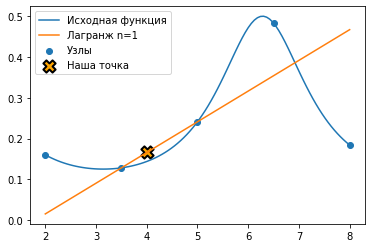

<b>Оценка приближения многочленом лагранжа 2-ой степени</b> <p>
    Отклонение найденной точки от действительной по оси Oy
    составило 0.00594

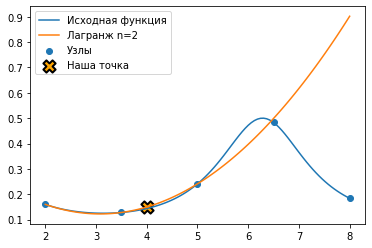

In [9]:
estimate(4, value_table, 1, f, x)
estimate(4, value_table, 2, f, x)

Посмотрим на одном графике, как меняется интерполяция в зависимости от степени многочлена Лагранжа

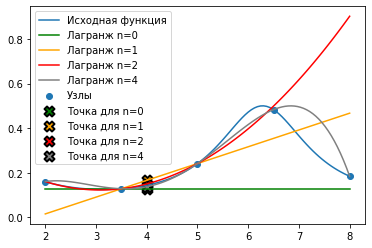

<b>Таблица найденных точек и их отклонений от реальных</b>

,x,y,error,degree
0,4,0.128051,0.015608,0
1,4,0.165708,0.022049,1
2,4,0.149601,0.005942,2
3,4,0.136925,0.006733,4


In [10]:
df_result = estimate_several(4, value_table, [0, 1, 2, 4], ['green', 'orange', 'red', 'gray'], f, x)

Построим график отклонений значений функции, полученных в результате интерполяции и степени многочлена Лагранжа

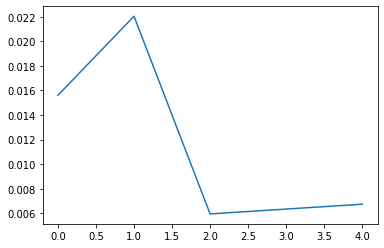

In [11]:
plt.plot(df_result['degree'], df_result['error'])
plt.show()